In [1]:
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.insert(0, '../../..')

from cde.density_estimator import MixtureDensityNetwork
from cde.density_estimator import ConditionalKernelDensityEstimation
from cd.data_collector import MatlabDataset
from cde.density_estimator import plot_conditional_hist, measure_percentile




Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
""" Open MATLAB file """

# matds = MatlabDataset('simple_queue_sr1_1M.mat') 
matds = MatlabDataset('../../data/simple_queue_sr0p5-4_1M.mat') # Normal 


 Dataset loaded from .mat file. Rows: 7877152   Columns: 3 


In [ ]:
""" Take samples and fit density model """
# best: 300000, 1000
data = matds.get_data(300000)
Y = data[:,0]
X = data[:,1:]

model = MixtureDensityNetwork("GMM_1hop_exp", ndim_x=2, n_centers=20, ndim_y=1,n_training_epochs=1000,hidden_sizes=(16, 16))
model.fit(X, Y)

In [11]:
""" Save the trained model into file """

with open('saves/1hop_exp.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)


In [3]:
""" Load the trained model from file """

dummy = MixtureDensityNetwork("GMM_1hop_exp", ndim_x=2, ndim_y=1)
dummy._setup_inference_and_initialize()

with open('saves/1hop_exp.pkl', 'rb') as input:
    dummy = pickle.load(input)

model = dummy


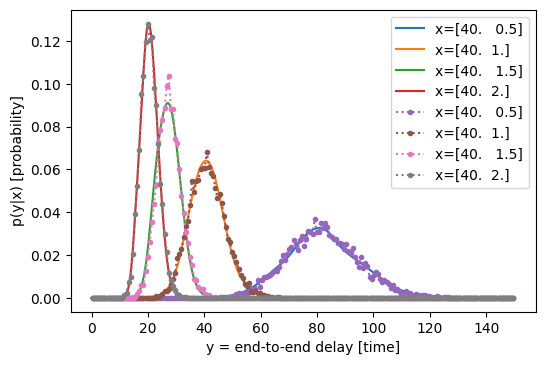

In [10]:
plt.ioff()

""" plot the fitted distribution """
x_cond_plot = np.array([[40, 0.5],[40,1], [40,1.5] , [40,2]])
y_lim = (0, 150)
fig = model.plot2d(x_cond_plot, ylim=y_lim, resolution=300, show=False, prefix='predicted',fsize=[6,4],fdpi=100,fxlabel="y = end-to-end delay [time]",fylabel="p(y|x) [probability]")

""" plot the conditional histogram """
data = matds.get_data(matds.n_records)
fig = plot_conditional_hist(data,x_cond_plot, ylim=y_lim, resolution=200, show=True, holdonfig=fig, prefix='measured',fsize=[6,4],fdpi=100)

plt.show()

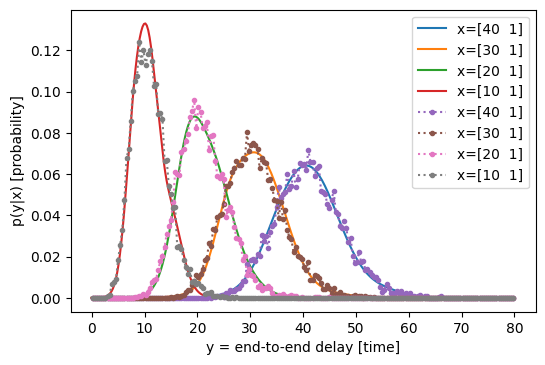

In [4]:
plt.ioff()

""" plot the fitted distribution """
x_cond_plot = np.array([[40, 1],[30, 1], [20, 1] , [10, 1]])
y_lim = (0, 80)
fig = model.plot2d(x_cond_plot, ylim=y_lim, resolution=300, show=False, prefix='predicted',fsize=[6,4],fdpi=100,fxlabel="y = end-to-end delay [time]",fylabel="p(y|x) [probability]")

""" plot the conditional histogram """
data = matds.get_data(matds.n_records)
fig = plot_conditional_hist(data,x_cond_plot, ylim=y_lim, resolution=200, show=True, holdonfig=fig, prefix='measured',fsize=[6,4],fdpi=100)

plt.show()

Calculating percentiles [96%]

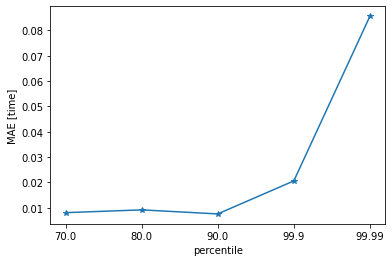

In [6]:

''' Calculate Normalized Mean Absolute Error (NMAE) '''


dataset = matds.get_data(matds.n_records)
#dataset = matds.get_data(int(matds.n_records*0.1))
testdataset = matds.get_data(100)
testdataset = testdataset[:,1:]
perc_arr = np.array([ 70,80,90,99.9,99.99])
NMAEs = []

for j in range(len(perc_arr)):
    p_perc = perc_arr[j]
    res = []
    for i in range(len(testdataset)):
        prog = (j*len(testdataset)+i)/(len(testdataset)*len(perc_arr))*100
        print('\rCalculating percentiles [%d%%]'%prog, end="")
        xc = np.array([testdataset[i,:]])
        measured_perc,num_samples,avg = measure_percentile(dataset=dataset,x_cond=xc,p_perc=p_perc)
        if num_samples > 1000:
            #predicted_perc = model.new_quantile_cdf_m(x_cond=xc,alpha=p_perc/100, eps=1e-3, init_bound=200)
            predicted_perc = model.find_perc(x_cond=xc,alpha=(100-p_perc)/100, eps=1e-3, init_bound=200)
            res.append(abs(measured_perc-predicted_perc)/measured_perc)
        else:
            continue

    nmae = np.mean(res)
    #print("percentile: ", p_perc ,", number of samples: ", len(res), " NMAE:", nmae)
    NMAEs.append(nmae)

fig, ax = plt.subplots()
ax.plot(range(len(NMAEs)),NMAEs, marker='*') #substitute actual plotting here
ax.set_xticks(range(len(NMAEs)))
ax.set_xticklabels(perc_arr)
plt.xlabel('percentile')
plt.ylabel('NMAE')

plt.show()